In [1]:
import matplotlib.pyplot  as plt
import os

## Analyze data

Our first step will be to analyze the dataset by just reading some samples of both pneumonia and normal cases. This will allows us to grasp what type of data we are handling and start establishing some pre-processing steps to clean-up the data and move forward to the models.

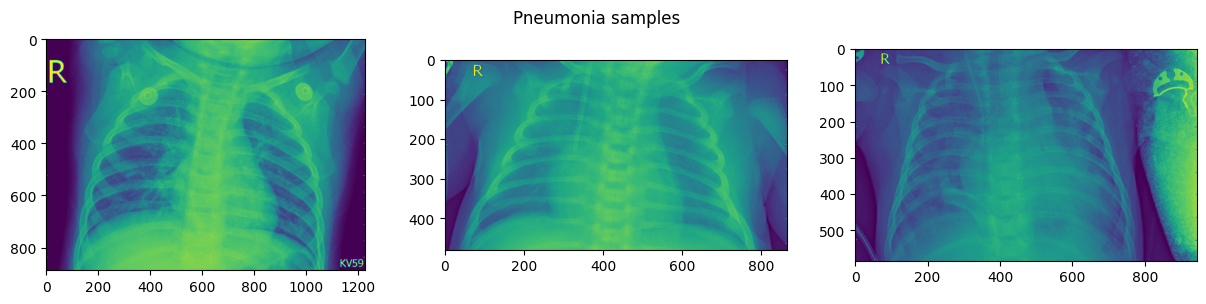

In [2]:
# Dataset is in your current working directory
train_dataset = os.path.join("chest_xray", "train")
pneumonia_dataset_path = os.path.join(train_dataset, "PNEUMONIA")

# Fetch Pneumonia sample
pneumonia_samples = os.listdir(pneumonia_dataset_path)[3:6]

# Plot pneumonia samples
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
fig.suptitle("Pneumonia samples")
for index, sample_path in enumerate(pneumonia_samples):
    sample = plt.imread(os.path.join(pneumonia_dataset_path, sample_path))
    axes[index].imshow(sample)

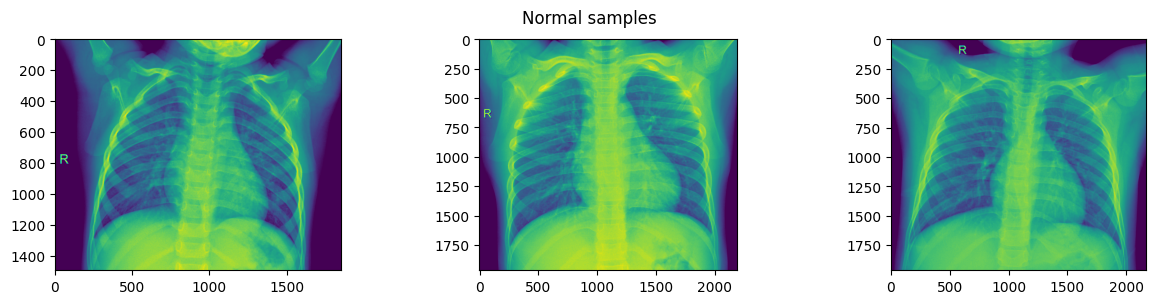

In [19]:
normal_dataset_path = os.path.join(train_dataset, "NORMAL")
normal_samples = os.listdir(normal_dataset_path)[3:6]

# Plot pneumonia samples
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
fig.suptitle("Normal samples")
for index, sample_path in enumerate(normal_samples):
    sample = plt.imread(os.path.join(normal_dataset_path, sample_path))
    axes[index].imshow(sample, cmap="")

In [26]:
# By printing a few normal samples of the dataset, we see the differences in naming.
# Part of our work will be to normalize this, in order to establish a clean pipeline.
print(normal_samples)

# Let's print the image information of the Normal samples
for index, sample_path in enumerate(normal_samples):
    sample = plt.imread(os.path.join(normal_dataset_path, sample_path))
    print(f"Shape: {sample.shape}")
    print(f"Array: \n {sample}")

# The following will point us to an inbalance in image sizes, which we will have to format.


['NORMAL2-IM-1260-0001.jpeg', 'IM-0656-0001-0001.jpeg', 'IM-0561-0001.jpeg']
Shape: (1495, 1854)
Array: 
 [[  0   0   0 ... 153 153 152]
 [  0   0   0 ... 153 152 150]
 [  0   0   0 ... 153 152 151]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
Shape: (1966, 2194)
Array: 
 [[107 112 109 ... 127 122 122]
 [113 116 114 ... 122 126 126]
 [112 112 113 ... 128 125 125]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
Shape: (1963, 2172)
Array: 
 [[ 0 79 72 ...  0  0  0]
 [ 0 80 75 ...  0  0  0]
 [ 0 81 76 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


Text(0.5, 1.0, 'Virus Pneumonia')

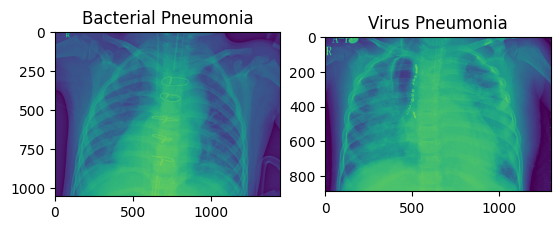

In [27]:
# Let's now analyze Pneumonia data and distinguish between viral and bacterial cases

bacteria_sample = "person2_bacteria_3.jpeg"
virus_sample = "person124_virus_246.jpeg"

fig, axes = plt.subplots(1,2)

bacteria_img = plt.imread(os.path.join(pneumonia_dataset_path, bacteria_sample))
virus_img = plt.imread(os.path.join(pneumonia_dataset_path, virus_sample))

axes[0].imshow(bacteria_img)
axes[0].set_title("Bacterial Pneumonia")

axes[1].imshow(virus_img)
axes[1].set_title("Virus Pneumonia")

In [32]:
def preprocess_pneumonia(dataset_path):
    "Read samples in dataset and identify via naming between bacteria and virus cases."
    bacteria_label = "bacteria"
    virus_label = "virus"

    data = {bacteria_label: [], virus_label: []}

    for sample in os.listdir(dataset_path):
        if bacteria_label in sample:
            data[bacteria_label].append(os.path.join(dataset_path, sample))
        elif virus_label in sample:
            data[virus_label].append(os.path.join(dataset_path, sample))

    return data


In [33]:
# Explore the nature of the Pneumonia training dataset 
pneumonia_dataset = os.path.join("chest_xray", "train", "PNEUMONIA")
train_data = preprocess_pneumonia(pneumonia_dataset)

print(f"Train Dataset")
print(f"Number of Cases of Bacterial Pneumonia: {len(train_data['bacteria'])}")
print(f"Number of Cases of Virus Pneumonia: {len(train_data['virus'])}")

pneumonia_dataset = os.path.join("chest_xray", "test", "PNEUMONIA")
test_data = preprocess_pneumonia(pneumonia_dataset)

print(f"Test Dataset")
print(f"Number of Cases of Bacterial Pneumonia: {len(test_data['bacteria'])}")
print(f"Number of Cases of Virus Pneumonia: {len(test_data['virus'])}")

pneumonia_dataset = os.path.join("chest_xray", "val", "PNEUMONIA")
val_data = preprocess_pneumonia(pneumonia_dataset)

print(f"Val Dataset")
print(f"Number of Cases of Bacterial Pneumonia: {len(val_data['bacteria'])}")
print(f"Number of Cases of Virus Pneumonia: {len(val_data['virus'])}")



Train Dataset
Number of Cases of Bacterial Pneumonia: 2530
Number of Cases of Virus Pneumonia: 1345
Test Dataset
Number of Cases of Bacterial Pneumonia: 242
Number of Cases of Virus Pneumonia: 148
Val Dataset
Number of Cases of Bacterial Pneumonia: 8
Number of Cases of Virus Pneumonia: 0


This shows in brief analysis that there are more bacterial pneumonia cases overall than virus. And more interestingly, no virus pneumonia cases are present in the validation set. In some studies, it actually seems that this passes completely ignored and there is a merge of all pneumonia cases into one box. This is not necessarily interesting for doctors, because sometimes the case may actually be to differ between pneumonia types, otherwise most people wouldn't be at the hospital in the first place.

So, with that in mind, we will join every piece of data into a larger dataset, create a csv that can be read with the information about the patients and thereafter save every piece of data orderly.

In [34]:
# With the already processed pneumonia paths, we can quickly add them into a single dictionary
# with the normal samples as well. This shows that we could simplify the whole pipeline, but
# this is enough to move forward, since we are gonna convert it into a simpler dataset anyway.
dataset_dict = {"label": [], "path": []}

for phase in ["train", "test", "val"]:
    normal_dataset = os.path.join("chest_xray", phase, "NORMAL")

    dataset_dict["path"].extend([os.path.join(normal_dataset, path) for path in os.listdir(normal_dataset)])
    dataset_dict["label"].extend(["normal"] * len(os.listdir(normal_dataset)))

label = "bacteria"
bacteria_data = train_data[label] + test_data[label] + val_data[label]
dataset_dict["path"].extend(bacteria_data)
dataset_dict["label"].extend([label]*len(bacteria_data))
label = "virus"
virus_data = train_data[label] + test_data[label] + val_data[label]
dataset_dict["path"].extend(virus_data)
dataset_dict["label"].extend([label]*len(virus_data))


import pandas as pd

xarray_df = pd.DataFrame(dataset_dict)


In [37]:
# Let's iterate over the rows of the dataframe to update the paths and move the images

xray_dataset = "xray_dataset"
os.mkdir(xray_dataset)

for index, row in xarray_df.iterrows():
    sample_path = row["path"]
    os.replace(sample_path, os.path.join(xray_dataset, f"sample_{index}.jpeg"))

In [38]:
for index, row in xarray_df.iterrows():
    row["path"] = os.path.join(xray_dataset, f"sample_{index}.jpeg")


,label,path
0,normal,xray_dataset/sample_0.jpeg
1,normal,xray_dataset/sample_1.jpeg
2,normal,xray_dataset/sample_2.jpeg
3,normal,xray_dataset/sample_3.jpeg
4,normal,xray_dataset/sample_4.jpeg
...,...,...
5851,virus,xray_dataset/sample_5851.jpeg
5852,virus,xray_dataset/sample_5852.jpeg
5853,virus,xray_dataset/sample_5853.jpeg
5854,virus,xray_dataset/sample_5854.jpeg


In [39]:
xarray_df.to_csv("xray_overview.csv")

Within this notebook, we started from the Kaggle dataset of xarrays, which was split into several folders. Explored it to understand a bit better its context and in the end organized everything into a single dataset. To finish, we will use opencv to check further a few samples and thereafter, we will be ready to start assembling our training pipeline.

In [7]:
import cv2
import os

dataset_path = "xray_dataset"

for index, sample in enumerate(os.listdir(dataset_path)):
    sample_path = os.path.join(dataset_path, sample)

    image = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_AREA)
    cv2.imwrite(sample_path, image)


Using opencv we can more easily format all images and resize them to prepare the training phase. We move now into the ML framework and later on, we will work again with opencv to process the images and enhance the quality of the results.